In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('CAM-01-SRV-lvm1.csv', header=None)
df.columns = ['Timestamp', 'Hostname', 'DiskNumber', 'Type', 'Offset', 'Size', 'ResponseTime']
df['Timestamp'] = df['Timestamp'].astype(np.int64)
df = df.sort_values(by='Timestamp')

In [3]:
file_pool_size = df.drop_duplicates(['Offset'])['Size'].sum()
total_request_byte = df['Size'].sum()
total_request_count = df.shape[0]


In [4]:
def make_requests():
    for row in df.itertuples():
        yield getattr(row, 'Offset'), getattr(row, 'Size')

In [5]:
class Server:  # 服务器(cache)
    def __init__(self, space):
        self.space = space  # cache大小
        self.remain = space  # cache剩余空间
        self.cache = OrderedDict()  # OrderDict() 模拟cache LRU方法
        self.hit_count = 0  # 命中次数
        self.hit_byte = 0
        self.miss_count = 0  # 未命中次数
        self.miss_byte = 0

    def _hit(self, fid, size):
        self.hit_count += 1
        self.hit_byte += size
        self.cache.move_to_end(fid)

    def _miss(self, fid, size):
        self.miss_count += 1
        self.miss_byte += size
        while self.remain < size:
            self.remain += self.cache.popitem(last=False)[-1]  # pop出第一个item
        self.cache[fid] = size
        self.remain -= size

    def handle(self, fid, size):  # 处理一次请求
        if fid in self.cache.keys():
            self._hit(fid, size)
        else:
            self._miss(fid, size)

    def hit_rate(self):
        try:
            return self.hit_count / (self.hit_count + self.miss_count)
        except:
            return 0

    def byte_hit_rate(self):
        try:
            return self.hit_byte / (self.hit_byte + self.miss_byte)
        except:
            return 0

In [6]:
class Dispatcher1:
    def __init__(self, cache_size, cache_number, simple=True):
        self.cache_number = cache_number
        self.big_cache = Server(cache_size * cache_number)
        self.small_caches = []
        for i in range(cache_number):
            server = Server(cache_size)
            self.small_caches.append(server)
        self.small_caches_heat = [0] * cache_number
        if simple:
            self.handle_requests = self.simple_hash
        else:
            self.handle_requests = self.load_balance
            self.file_mapper = {}
            for row in df.drop_duplicates(['Offset']).itertuples():
                fid = getattr(row, 'Offset')
                self.file_mapper[fid] = (fid // 10000 % 1000000) & 0b11111 % cache_number

    def load_balance(self, fid, size):
        server = self.file_mapper[fid]
        if fid in self.small_caches[server].cache.keys():
            self.small_caches[server].handle(fid, size)
            self.small_caches_heat[self.file_mapper[fid]] += size
        else:
            server = self.small_caches_heat.index(min(self.small_caches_heat))
            self.small_caches[server].handle(fid, size)
            self.file_mapper[fid] = server
        self.big_cache.handle(fid, size)

    def simple_hash(self, fid, size):
        self.small_caches[(fid // 10000 % 1000000) & 0b11111 % self.cache_number].handle(fid, size)

In [7]:
class Dispatcher2:
    def __init__(self, cache_size, cache_number, simple=True):
        self.cache_number = cache_number
        self.big_cache = Server(cache_size * cache_number)
        self.small_caches = []
        for i in range(cache_number):
            server = Server(cache_size)
            self.small_caches.append(server)
        self.small_caches_heat = [0] * cache_number
        if simple:
            self.handle_requests = self.simple_hash
        else:
            self.handle_requests = self.load_balance
            self.file_mapper = {}
            for row in df.drop_duplicates(['Offset']).itertuples():
                fid = getattr(row, 'Offset')
                self.file_mapper[fid] = (fid // 10000 % 1000000) & 0b11111 % cache_number

    def load_balance(self, fid, size):
        server = self.file_mapper[fid]
        if fid in self.small_caches[server].cache.keys():
            self.small_caches[server].handle(fid, size)
        else:
            server = self.small_caches_heat.index(min(self.small_caches_heat))
            self.small_caches[server].handle(fid, size)
            self.file_mapper[fid] = server
        self.small_caches_heat[server] += size
        self.big_cache.handle(fid, size)

    def simple_hash(self, fid, size):
        self.small_caches[(fid // 10000 % 1000000) & 0b11111 % self.cache_number].handle(fid, size)

In [8]:
FILE_NUM = len(df['Offset'].value_counts())
CACHE_NUMBER = 4
print(FILE_NUM)
print(CACHE_NUMBER)

dispatcher1_small_server_hit_byte_ratio = []
dispatcher2_small_server_hit_byte_ratio = []
big_server_hit_byte_ratio = []

heat1_1 = []
heat1_2 = []
heat1_3 = []
heat1_4 = []
heat2_1 = []
heat2_2 = []
heat2_3 = []
heat2_4 = []

hit_ratio1 = []
hit_ratio2 = []
hit_ratio_big = []

small_hit_ratio1_1 = []
small_hit_ratio1_2 = []
small_hit_ratio1_3 = []
small_hit_ratio1_4 = []

small_hit_ratio2_1 = []
small_hit_ratio2_2 = []
small_hit_ratio2_3 = []
small_hit_ratio2_4 = []

time_array = []


small_cache_count_hit_ratio = []
small_cache_byte_hit_ratio = []

13966057
4


In [9]:
handle_1 = []
handle_2 = []
handle_3 = []
handle_4 = []
handle_b = []
pre1 = 0
pre2 = 0
pre3 = 0
pre4 = 0


In [10]:
cache_size = 16384000000
dispatcher = Dispatcher1(cache_size, CACHE_NUMBER, False)
time = 0
for fid, size in tqdm(make_requests()):
    dispatcher.handle_requests(fid, size)
    time += 1
    if time % 1000000 == 0:
        time_array.append(time)        
        handle_1.append(dispatcher.small_caches[0].hit_byte + dispatcher.small_caches[0].miss_byte)
        handle_2.append(dispatcher.small_caches[1].hit_byte + dispatcher.small_caches[1].miss_byte)
        handle_3.append(dispatcher.small_caches[2].hit_byte + dispatcher.small_caches[2].miss_byte)
        handle_4.append(dispatcher.small_caches[3].hit_byte + dispatcher.small_caches[3].miss_byte)
    

45283980it [04:09, 181137.06it/s]


In [11]:
colors = ['gold', 'green', 'pink', 'brown']

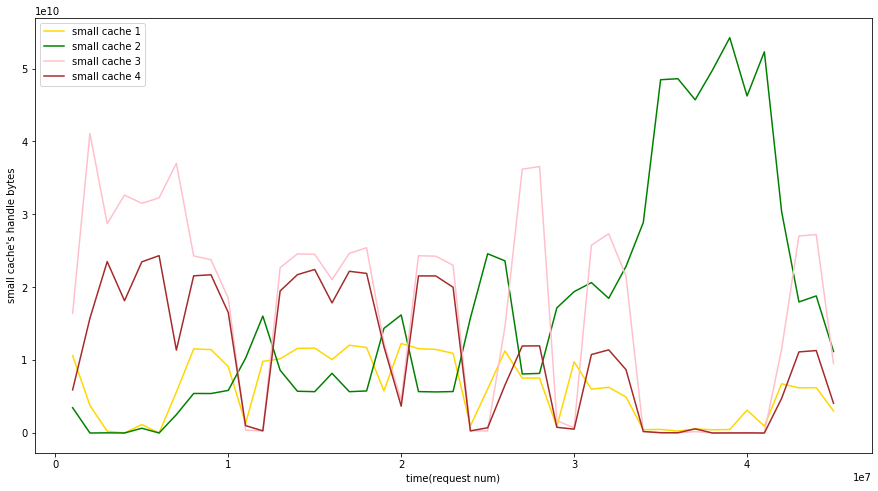

In [12]:

plt.figure(figsize=(15, 8))
plt.plot(time_array, handle_1, color=colors[0], label='small cache 1')
plt.plot(time_array, handle_2, color=colors[1], label='small cache 2')
plt.plot(time_array, handle_3, color=colors[2], label='small cache 3')
plt.plot(time_array, handle_4, color=colors[3], label='small cache 4')

plt.xlabel("time(request num)")
plt.ylabel("small cache's handle bytes")
plt.legend()
plt.show()


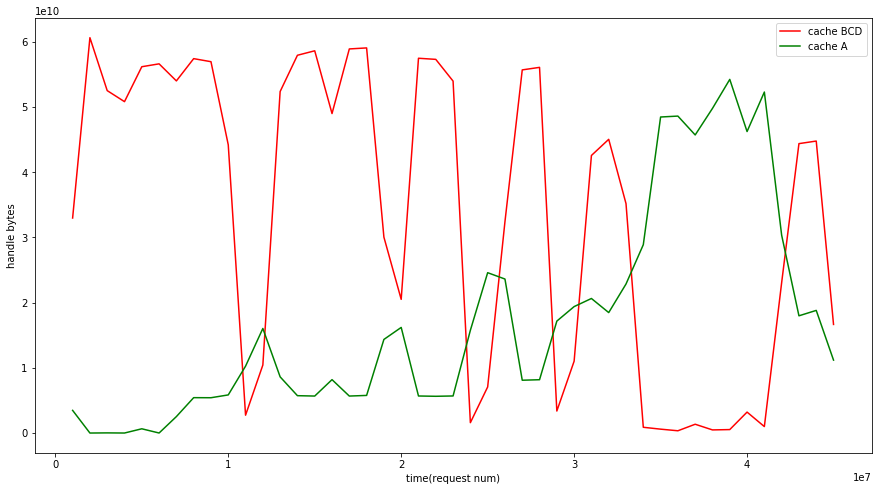

In [13]:
handle = []
for i in range(len(handle_1)):
    handle.append(handle_1[i] + handle_4[i] + handle_3[i])

plt.figure(figsize=(15, 8))
plt.plot(time_array, handle, color='red', label='cache BCD')
plt.plot(time_array, handle_2, color=colors[1], label='cache A')

plt.xlabel("time(request num)")
plt.ylabel("handle bytes")
plt.legend()
plt.show() 
    